MEG Signal Classification Using PLV and a Simple Neural Network
---------------------------------------------------------------

This notebook demonstrates MEG classification using Phase Locking Value (PLV) and a simple neural network. The notebook reads MEG ICANN 2011 dataset, computes PLV for each of the channels and classifies the information using a neural network.

For more information, please refer to https://nextonsblog.wordpress.com/?p=2577

In [1]:
import numpy as np
import scipy.io

from scipy.signal import hilbert
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Global configuration.
FILENAME = "../../data/megicann_train_v2.mat"
DATASET_X = 'train_day1'
DATASET_Y = 'class_day1'
FREQ_DOMAINS = [5]
VALIDATION_SAMPLES = 0.2
N_EPOCHS = 50

# Ensure that the results can be repeated
np.random.seed(42)

In [3]:
# Original data is in format train[frequency][sample, channel, time].
# make different frequencies appear as channels and swap channel and time.
def preprocess_x(raw_data):
    # Move different frequencies to channels
    samples = raw_data[0, FREQ_DOMAINS[0]][:]
    for freq_domain in FREQ_DOMAINS[1:]:
        samples = np.concatenate([samples, raw_data[0, freq_domain][:]], axis=1)
        
    # Normalize the data within each sample (per channel) and ensure that type is ok
    for i, sample in enumerate(samples):
        sample_mean = sample.mean(axis=1);
        sample_std = sample.std(axis=1);
        samples[i] = ((sample.transpose() - sample_mean) / sample_std).transpose()

    samples = hilbert(samples)
    samples = samples / abs(samples)
    
    # Transpose the data to [sample, time, channel] format
    samples = np.transpose(samples, axes=(0, 2, 1))
    
    return samples

def preprocess_y(y):
    y = np.array(y, dtype='int').ravel()
    num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

In [4]:
def plv(samples):
    plvs = []
    for sample in samples:
        plvs.append(np.abs(np.dot(sample.conj().T, sample)) / 200)
        
    return np.asarray(plvs)

In [5]:
# Load samples and preprocess them
train_dict = scipy.io.loadmat(FILENAME)
train_dataset_x = preprocess_x(train_dict[DATASET_X])
train_dataset_y = preprocess_y(train_dict[DATASET_Y][:,0])

# Pick validation dataset into separate variable. It's needed for computing the confusion matrix
_val_dataset_y = train_dict[DATASET_Y][:,0]

# Remove train_dict to save some memory
train_dict = None

In [6]:
train_dataset_x = plv(train_dataset_x)
train_dataset_x[train_dataset_x < 0.5] = 0
train_dataset_x[train_dataset_x >= 0.5] = 1

# Split samples into training and validation sets
num_val_samples = int(np.ceil(VALIDATION_SAMPLES * len(train_dataset_x) - 1))
val_dataset_x = train_dataset_x[:num_val_samples]
val_dataset_y = train_dataset_y[:num_val_samples]
_val_dataset_y = _val_dataset_y[:num_val_samples]
train_dataset_x = train_dataset_x[num_val_samples:]
train_dataset_y = train_dataset_y[num_val_samples:]

num_classes = train_dataset_y.shape[1]

In [7]:
# Helpers for initializing a graph for visualization
def init_fig():
    plt.figure()
    plt.xlabel('Channel')
    plt.ylabel('Channel')

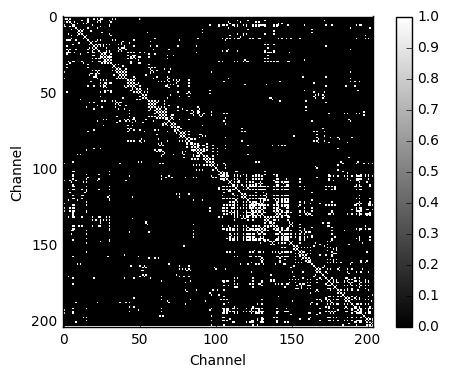

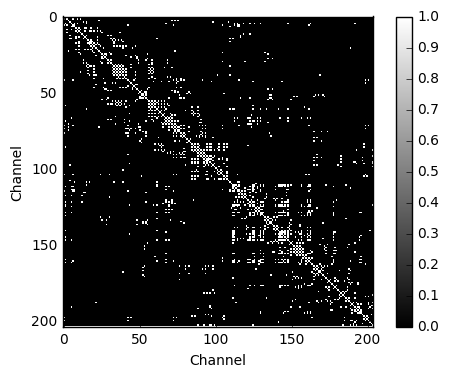

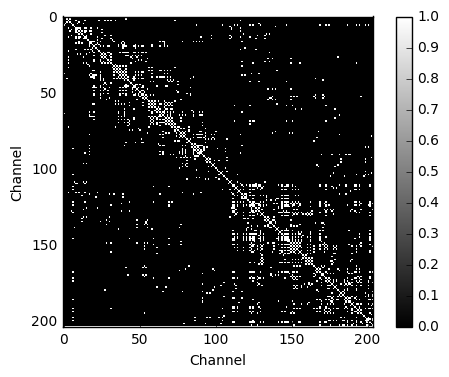

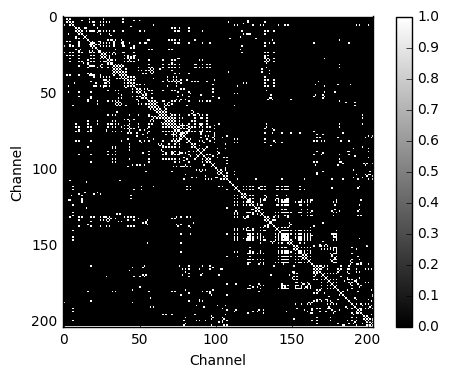

In [8]:
# Visualize few samples
init_fig()
plt.imshow(train_dataset_x[0], interpolation='nearest', cmap=plt.get_cmap('gray'))
plt.colorbar()

init_fig()
plt.imshow(train_dataset_x[1], interpolation='nearest', cmap=plt.get_cmap('gray'))
plt.colorbar()

init_fig()
plt.imshow(train_dataset_x[2], interpolation='nearest', cmap=plt.get_cmap('gray'))
plt.colorbar()

init_fig()
plt.imshow(train_dataset_x[3], interpolation='nearest', cmap=plt.get_cmap('gray'))
plt.colorbar()

In [9]:
# Fold the adjacency matrix into 1d array
train_dataset_x = np.reshape(train_dataset_x, (train_dataset_x.shape[0], train_dataset_x.shape[1] *  train_dataset_x.shape[2]))
val_dataset_x = np.reshape(val_dataset_x, (val_dataset_x.shape[0], val_dataset_x.shape[1] *  val_dataset_x.shape[2]))

In [10]:
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(train_dataset_x.shape[1],)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(train_dataset_y.shape[1], activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.fit(train_dataset_x, train_dataset_y,
          batch_size=100,
          epochs=10,
          verbose=1, validation_data=(val_dataset_x, val_dataset_y))

Train on 542 samples, validate on 135 samples
Epoch 1/10
542/542 [==============================] - 1s - loss: 1.6417 - acc: 0.3893 - val_loss: 1.4870 - val_acc: 0.5037
Epoch 2/10
542/542 [==============================] - 1s - loss: 1.2599 - acc: 0.7159 - val_loss: 1.3071 - val_acc: 0.5704
Epoch 3/10
542/542 [==============================] - 1s - loss: 0.9842 - acc: 0.8303 - val_loss: 1.1670 - val_acc: 0.5481
Epoch 4/10
542/542 [==============================] - 2s - loss: 0.7519 - acc: 0.9114 - val_loss: 1.0614 - val_acc: 0.5778
Epoch 5/10
542/542 [==============================] - 2s - loss: 0.5513 - acc: 0.9982 - val_loss: 0.9980 - val_acc: 0.6000
Epoch 6/10
542/542 [==============================] - 1s - loss: 0.3874 - acc: 1.0000 - val_loss: 0.9627 - val_acc: 0.5926
Epoch 7/10
542/542 [==============================] - 1s - loss: 0.2646 - acc: 1.0000 - val_loss: 0.9494 - val_acc: 0.6444
Epoch 8/10
542/542 [==============================] - 1s - loss: 0.1814 - acc: 1.0000 - val_l

In [12]:
confusion_matrix(_val_dataset_y, model.predict_classes(val_dataset_x))

 96/135 [====================>.........] - ETA: 0s

array([[13, 11,  1,  0,  0],
       [10, 24,  0,  4,  0],
       [ 9,  9,  1,  3,  0],
       [ 1,  0,  0, 26,  1],
       [ 0,  0,  0,  0, 22]])